# A glimpse of deep learning -- unravel the power via a regression  probelm

  从2012年开始，由于在imagenet上的出色表现，深度学习和神经网络慢慢地跃入人们的视野。这里我们使用神经网络解决一个回归问题--预测房屋的价格（具体数据在[kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels?sortBy=hotness&group=everyone&pageSize=20&language=all&competitionId=5407&key=424isu&state%5BcompetitionTabState%5D%5BactivePane%5D=kernels&state%5BcompetitionTabState%5D%5BactiveTab%5D=Kernels&state%5BcompetitionTabState%5D%5BisNewTopic%5D=false&state%5BcompetitionTabState%5D%5BtopicId%5D=&state%5BcompetitionTabState%5D%5BsubmissionsPage%5D=1&state%5BcompetitionTabState%5D%5BsubmissionsGroup%5D=all&state%5BcompetitionTabState%5D%5BsubmissionsSortBy%5D=date])上有）,愿数据有80以上的变量，我们这里尝试一下使用Gluon在没有进行过多的fearture engineering的情况下来预测一下房价（本篇内容主要参考[这里](http://zh.gluon.ai/chapter_supervised-learning/kaggle-gluon-kfold.html)）。

## 1 Preprocessing data

  这里需要是先将train data和test data合并起来之后，再进行数据的清洗和处理.

In [1]:
from mxnet import init

/Users/jiangchaodi/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import pandas as pd
import numpy as np

train = pd.read_csv('./data/kaggle_house_train.csv')
test = pd.read_csv('./data/kaggle_house_test.csv')
all_x = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                      test.loc[:, 'MSSubClass':'SaleCondition']))

In [3]:
all_x.index = range(all_x.shape[0])

In [4]:
#数值型数据以及缺失数据量<500（超过500，舍弃）
set_notdrop = all_x.columns[all_x.isnull().sum(axis=0)<500]
set_num = all_x.dtypes[train.dtypes != "object"].index
num_cols = list(set_notdrop & set_num)  #注意id也是我们不需要的
len(num_cols)

36

In [5]:
#字符型数据以及缺失数据量<500（超过500，舍弃）
set_cat = all_x.dtypes[all_x.dtypes=='object'].index
cat_cols = list(set_notdrop & set_cat)
len(cat_cols)

38

In [6]:
for col in cat_cols:
    print(col,'\n',all_x[col].value_counts(),'\n')

MSZoning 
 RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64 

Street 
 Pave    2907
Grvl      12
Name: Street, dtype: int64 

LotShape 
 Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64 

LandContour 
 Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64 

Utilities 
 AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64 

LotConfig 
 Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64 

LandSlope 
 Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64 

Neighborhood 
 NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenk

In [7]:
import sklearn
from sklearn.base import BaseEstimator,TransformerMixin

#首先是选择变量的类
class Selecfeatures(BaseEstimator,TransformerMixin):
    def __init__(self,cols):
        self.cols = cols
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return X[self.cols].values

In [8]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('Select features',Selecfeatures(num_cols)),
    ('Imputer',Imputer(strategy="median")),
    ('Standard scalor',StandardScaler())
])

In [9]:
all_x_num = pd.DataFrame(num_pipeline.fit_transform(all_x),columns=num_cols)

In [10]:
all_x_num.shape

(2919, 36)

In [11]:
all_x_cat = pd.get_dummies(all_x[cat_cols])

In [12]:
X = pd.concat([all_x_num,all_x_cat],axis=1)

In [13]:
train_num = train.shape[0]
X_train = X[:train_num].as_matrix() #.as_matrix turn to numpy array
y_train = train.SalePrice.as_matrix().reshape(-1,1)
X_test =X[train_num:].as_matrix()

## 2 Define a model

In [14]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon

X_train = nd.array(X_train)
y_train = nd.array(y_train)
y_train.reshape((train_num, 1))

X_test = nd.array(X_test)

In [15]:
square_loss = gluon.loss.L2Loss()

In [16]:
def get_rmse_log(net, X_train, y_train):
    num_train = X_train.shape[0]
    clipped_preds = nd.clip(net(X_train), 1, float('inf'))
    return np.sqrt(2 * nd.sum(square_loss(
        nd.log(clipped_preds), nd.log(y_train))).asscalar() / num_train)#mean  square log error

In [17]:
def get_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(2))
        #net.add(gluon.nn.Dropout(0.1))
        net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

In [18]:
#define train process
%matplotlib inline
from mxnet import init
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def train(net, X_train, y_train, X_test, y_test, epochs,
          verbose_epoch, learning_rate, weight_decay,batch_size = 100):
    train_loss = []
    if X_test is not None:
        test_loss = []
    
    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    data_iter_train = gluon.data.DataLoader(
        dataset_train, batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': learning_rate,
                             'wd': weight_decay})
    net.collect_params().initialize(init.Xavier(),force_reinit=True)#使用Xavier 进行初始化
    for epoch in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)

            cur_train_loss = get_rmse_log(net, X_train, y_train)
        if epoch > verbose_epoch:
            print("Epoch %d, train loss: %f" % (epoch, cur_train_loss))
        train_loss.append(cur_train_loss)
        if X_test is not None:
            cur_test_loss = get_rmse_log(net, X_test, y_test) #net 和上面相同
            test_loss.append(cur_test_loss)
    plt.plot(train_loss)
    plt.legend(['train'])
    if X_test is not None:
        plt.plot(test_loss)
        plt.legend(['train','test'])
    plt.show()
    if X_test is not None:
        return cur_train_loss, cur_test_loss
    else:
        return cur_train_loss

In [19]:
def k_fold_cross_valid(k, epochs, verbose_epoch, X_train, y_train,
                       learning_rate, weight_decay):
    assert k > 1
    fold_size = X_train.shape[0] // k
    train_loss_sum = 0.0
    test_loss_sum = 0.0
    for test_i in range(k):
        X_val_test = X_train[test_i * fold_size: (test_i + 1) * fold_size, :]
        y_val_test = y_train[test_i * fold_size: (test_i + 1) * fold_size]

        val_train_defined = False
        for i in range(k):
            if i != test_i:
                X_cur_fold = X_train[i * fold_size: (i + 1) * fold_size, :]
                y_cur_fold = y_train[i * fold_size: (i + 1) * fold_size]
                if not val_train_defined:
                    X_val_train = X_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    X_val_train = nd.concat(X_val_train, X_cur_fold, dim=0)
                    y_val_train = nd.concat(y_val_train, y_cur_fold, dim=0)
        net = get_net()
        train_loss, test_loss = train(
            net, X_val_train, y_val_train, X_val_test, y_val_test,
            epochs, verbose_epoch, learning_rate, weight_decay)
        train_loss_sum += train_loss
        print("Test loss: %f" % test_loss)
        test_loss_sum += test_loss
    return train_loss_sum / k, test_loss_sum / k

In [20]:
k = 5
epochs = 100
verbose_epoch = 95
learning_rate = 0.2
weight_decay = 50

Epoch 96, train loss: 0.142785
Epoch 97, train loss: 0.141982
Epoch 98, train loss: 0.142120
Epoch 99, train loss: 0.141784


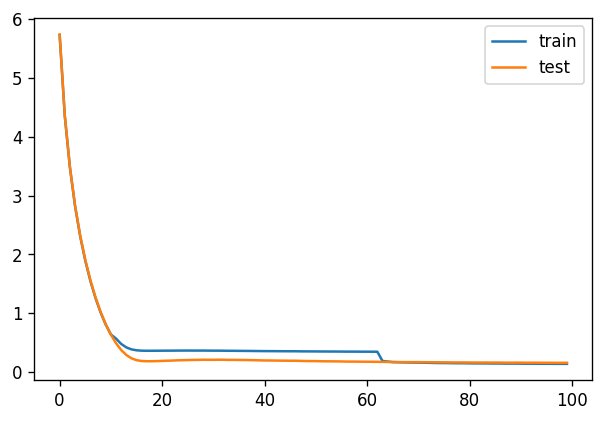

Test loss: 0.159621
Epoch 96, train loss: 0.137754
Epoch 97, train loss: 0.137244
Epoch 98, train loss: 0.136755
Epoch 99, train loss: 0.136547


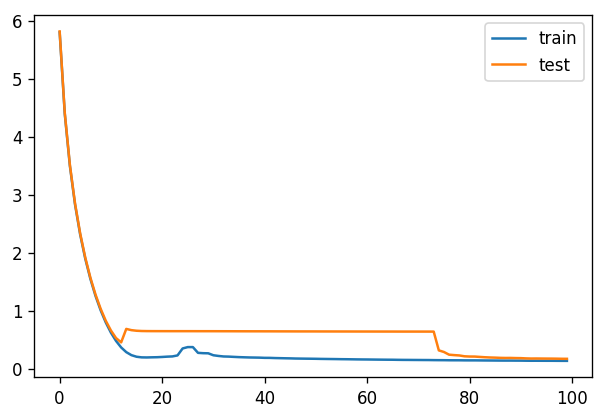

Test loss: 0.171769
Epoch 96, train loss: 0.137049
Epoch 97, train loss: 0.137112
Epoch 98, train loss: 0.136183
Epoch 99, train loss: 0.136063


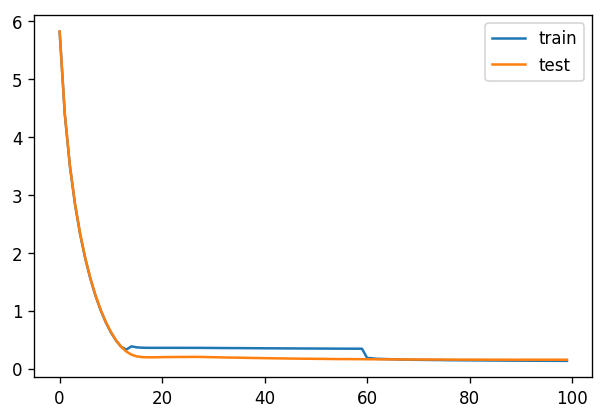

Test loss: 0.155752
Epoch 96, train loss: 0.145907
Epoch 97, train loss: 0.145468
Epoch 98, train loss: 0.145149
Epoch 99, train loss: 0.145097


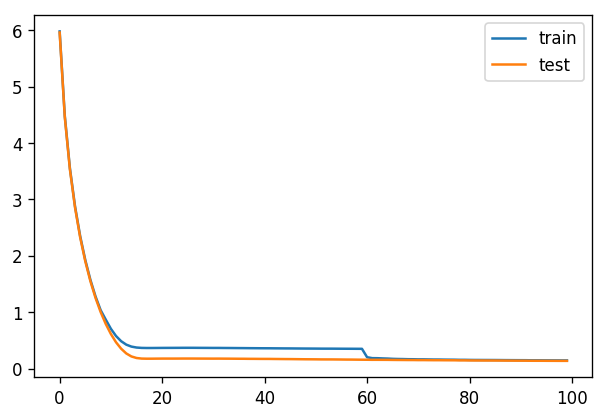

Test loss: 0.137005
Epoch 96, train loss: 0.138481
Epoch 97, train loss: 0.138122
Epoch 98, train loss: 0.138066
Epoch 99, train loss: 0.137761


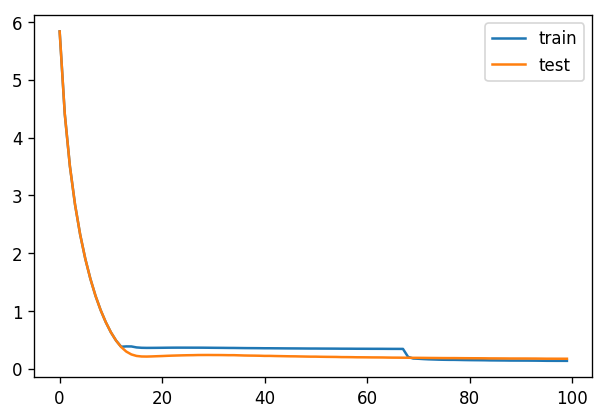

Test loss: 0.174314
5-fold validation: Avg train loss: 0.139451, Avg test loss: 0.159692


In [21]:
train_loss, test_loss = k_fold_cross_valid(k, epochs, verbose_epoch, X_train,
                                           y_train, learning_rate, weight_decay)
print("%d-fold validation: Avg train loss: %f, Avg test loss: %f" %
      (k, train_loss, test_loss))

In [22]:
def learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
          weight_decay):
    net = get_net()
    train(net, X_train, y_train, None, None, epochs, verbose_epoch,
          learning_rate, weight_decay)
    preds = net(X_test).asnumpy()
    SalePrice= pd.Series(preds.reshape(1, -1)[0])
    Id = test['Id']
    submission = pd.DataFrame({'Id':Id,
                              'SalePrice':SalePrice})
    submission.to_csv('submission.csv', index=False)

Epoch 96, train loss: 0.135364
Epoch 97, train loss: 0.134963
Epoch 98, train loss: 0.135079
Epoch 99, train loss: 0.134783


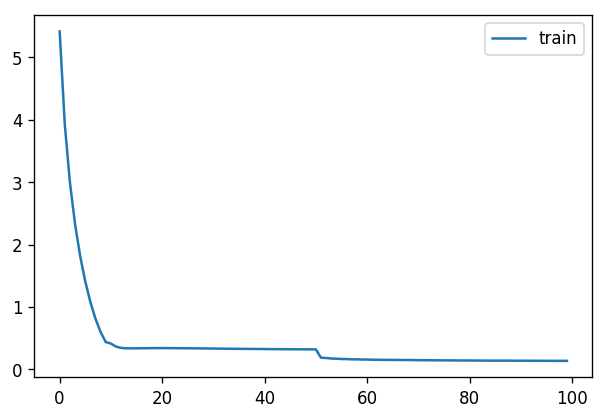

In [23]:
learn(epochs,verbose_epoch,X_train,y_train,test,learning_rate,weight_decay)

# 3 summary


  在没有使用任何feature enginering的情况下，尝试了使用深度学习进行回归预测，并在kaggle上提交了预测结果，虽然
结果一般。如果我需要改进我的预测结果的话，那么我需要做的可能是：  
1，feature engineering。  
2，调参数。特别是后者会显得尤为重要，从某种意义上来说，调参有点像做实验，你永远不知道自己的参数会有怎样的表现。好在使用良好的调参数技巧会大大减少这种痛苦，比如前面介绍过的gridsearch、randomsearch还有一种依赖实验设计（DoE）的方法。